# PWC Optimization

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt
from scipy.optimize import minimize, OptimizeResult


@dataclass
class OptimizationResult:
    result: OptimizeResult
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]

    def plot(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()


@dataclass
class SimulationResult:
    times: npt.NDArray[np.float64]
    unitaries: list[qt.Qobj]
    states: list[qt.Qobj]
    infidelities: list[float]

    @property
    def dimension(self) -> int:
        return self.states[0].shape[0]

    @property
    def populations(self) -> npt.NDArray:
        return np.abs(np.array(self.states).squeeze()) ** 2

    def display_bloch_sphere(self):
        states = np.array(self.states).squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self):
        qv.plot_population_dynamics(
            sample_times=self.times,
            populations={
                rf"$|{k}\rangle$": self.populations[:, k] for k in range(self.dimension)
            },
        )

    def print_final_populations(self):
        population = self.populations[-1]
        for k in range(self.dimension):
            print(f"|{k}> : {population[k]:>6.2%}")

    def plot_unitary_infidelities(self):
        plt.plot(self.times, self.infidelities)
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.ylim(0, 1)


class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        detuning: float,
        anharmonicity: float,
        segment_count: int,
        segment_width: float,
    ):
        self.dimension = dimension
        self.detuning = detuning
        self.anharmonicity = anharmonicity
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.a = qt.destroy(self.dimension)
        self.ad = self.a.dag()
        self.H_sys = self.system_hamiltonian()

    def system_hamiltonian(self) -> qt.Qobj:
        omega = 2 * np.pi * self.detuning
        alpha = 2 * np.pi * self.anharmonicity
        a = self.a
        ad = self.ad
        H_sys = omega * ad * a + 0.5 * alpha * ad * ad * a * a
        return H_sys

    def pwc_unitary(self, value: complex, duration: float) -> qt.Qobj:
        H_ctrl = 0.5 * (self.ad * value + self.a * np.conj(value))
        H = self.H_sys + H_ctrl
        U = (-1j * H * duration).expm()
        return U

    def objective_function(self, params: npt.NDArray[np.float64]) -> float:
        pulse = self.params_to_pulse(params)
        U = qt.qeye(self.dimension)
        for value in pulse:
            U = self.pwc_unitary(value, self.segment_width) * U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(self, U1: qt.Qobj, U2: qt.Qobj) -> float:
        return 1 - np.abs((U1.dag() * U2).tr() / self.dimension) ** 2

    def random_params(self) -> npt.NDArray[np.float64]:
        return np.random.uniform(-1, 1, 2 * self.segment_count)

    def params_to_pulse(
        self,
        params: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.complex128]:
        params = params.reshape((self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
        initial_params: npt.NDArray[np.float64],
        target_unitary: qt.Qobj,
    ) -> OptimizationResult:
        self.target_unitary = target_unitary
        result = minimize(
            self.objective_function,
            initial_params,
            method="BFGS",
        )
        params = result.x
        pulse = self.params_to_pulse(params)
        times = np.linspace(0, self.duration, self.segment_count + 1)
        return OptimizationResult(
            result=result,
            times=times,
            params=params,
            pulse=pulse,
        )

    def simulate(
        self,
        pulse: npt.NDArray[np.complex128],
        steps_per_segment: int,
    ) -> SimulationResult:
        pulse = np.repeat(pulse, steps_per_segment)
        segment_count = self.segment_count * steps_per_segment
        times = np.linspace(0, self.duration, segment_count + 1)
        unitaries = [qt.qeye(self.dimension)]
        states = [qt.basis(self.dimension, 0)]
        infidelities = [0.0]
        segment_width = self.segment_width / steps_per_segment
        for value in pulse:
            U = self.pwc_unitary(value, segment_width) * unitaries[-1]
            unitaries.append(U)
            state = U * states[0]
            states.append(state)
            infidelity = self.unitary_infidelity(U, self.target_unitary)
            infidelities.append(infidelity)
        return SimulationResult(
            times=times,
            unitaries=unitaries,
            states=states,
            infidelities=infidelities,
        )

In [2]:
optimizer = PulseOptimizer(
    dimension=3,
    detuning=0.0,
    anharmonicity=-0.3,
    segment_count=10,
    segment_width=2.0,
)

In [3]:
initial_params = optimizer.random_params()
initial_params

array([-0.94972922, -0.27782744,  0.51594961, -0.05994843, -0.35495649,
        0.35655506, -0.56099599, -0.8959299 , -0.14441306, -0.53216355,
       -0.15818235, -0.83383609,  0.82714151, -0.39841984,  0.68156778,
       -0.28577419,  0.75058885, -0.3188946 , -0.20213882,  0.01062214])

In [4]:
target_unitary = qt.qeye(3)
target_unitary

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

In [5]:
opt_result = optimizer.optimize(
    initial_params=initial_params,
    target_unitary=target_unitary,
)
opt_result

OptimizationResult(result=  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.4375167722846527e-11
        x: [-9.877e-01 -2.982e-01 ... -1.703e-01  6.262e-02]
      nit: 18
      jac: [-3.904e-06 -3.904e-06 ... -3.234e-06  1.788e-07]
 hess_inv: [[ 6.348e-01 -2.259e-02 ... -1.256e-01 -1.868e-02]
            [-2.259e-02  7.054e-01 ... -5.511e-02 -4.389e-02]
            ...
            [-1.256e-01 -5.511e-02 ...  7.328e-01 -1.027e-02]
            [-1.868e-02 -4.389e-02 ... -1.027e-02  6.986e-01]]
     nfev: 567
     njev: 27, times=array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]), params=array([-0.98770259, -0.29815817,  0.23948609, -0.40074561,  0.06750814,
       -0.01955658, -0.19518198, -1.03191547, -0.09968469, -0.41165402,
       -0.05584128, -0.71622879,  0.2824941 , -0.3633598 ,  0.31093559,
        0.12071353,  0.3017581 , -0.16519968, -0.17034229,  0.06262499]), pulse=array([-0.98770259-0.29815817j,  0.23948609-0.40074561j,
 

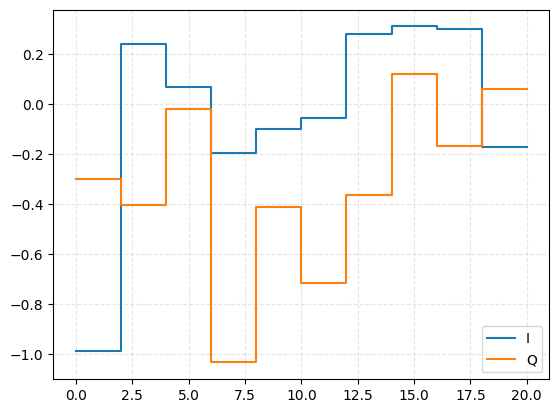

In [6]:
opt_result.plot()

In [7]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=20,
)

In [8]:
sim_result.print_final_populations()

|0> : 100.00%
|1> :  0.00%
|2> :  0.00%


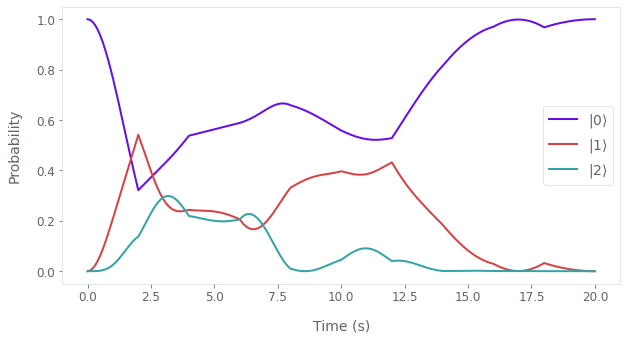

In [9]:
sim_result.plot_populations()

In [10]:
sim_result.display_bloch_sphere()

<IPython.core.display.Javascript object>

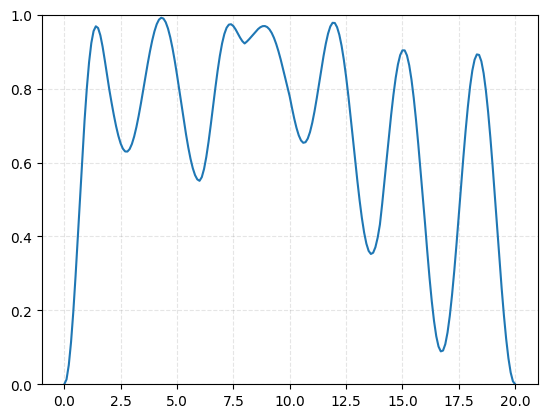

In [11]:
sim_result.plot_unitary_infidelities()